In [10]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd 

In [91]:
V = np.array([[0.04, 0], [0, 0.04]])
p = np.array([[1], [1]])
y_bar = np.array([[1.4], [.8]])
R_f = 1

# Funções Básicas

In [92]:
import numpy as np
from scipy.optimize import minimize

def portfolio_return(w, er):
    """
    Dado o portfolio e o retorno esperado, 
    calcula o retorno do portfolio. 
    
        Parãmetros: 
        w (np.array nx1): portfolio
        er (np.array nx1): vetor de retornos esperados
        
        Retorna 
        mu(np.array 1x1): Retorno do portfolio
    
    """
    mu = w.T@er
    return mu

def portfolio_volatiliy(w, cov):
    """
    Dado o portfolio e a matriz de covariância, 
    calcula a volatilidade do portfolio. 
    
        Parãmetros: 
        w (np.array nx1): portfolio
        cov(np.array nxn): matriz de covariancia
        
        Retorna 
        sigma(np.array 1x1): Volatilidade do Portfolio
    
    """

    sigma = np.sqrt(w.T@cov@w)
    return sigma

def portfolio_price(w, p):
    """
    Dado o portfolio e o vetor de preços, 
    calcula o preço do portfolio. 
    
        Parãmetros: 
        w (np.array nx1): portfolio
        p(np.array nx1): vetor de preços
        
        Retorna 
        p_x(np.array 1x1): preço do ativo
    
    """
    return w.T@p
    
    
def norm(w, er, cov):
    """
    Dado o portfolio, a matriz de covariância e o retorno esperado
    calcula ||x|| = sqrt(E[x^2]) = sqrt(E[x]^2+ vol(x)^2)  
    
        Parãmetros: 
        w (np.array nx1): portfolio
        er (np.array nx1): vetor de retornos esperados
        cov(np.array nx1): matriz de covariancia
        
        Retorna 
        norm(np.array 1x1): norma do Portfolio
    
    """
    norm = np.sqrt((portfolio_return(w, er)**2+portfolio_volatiliy(w, cov)**2))
    return norm

# Encontrando a fronteira eficiente

In [93]:
def global_minimal_volatility(cov, p):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n).reshape(n, 1)
    
    #Constraints
    prices_sum_to_1 = {'type': 'eq',
                        'fun': lambda w: w.T@p - 1
    }
   
    results = minimize(portfolio_volatiliy, init_guess,
                       args=(cov,), method="SLSQP",
                       options={"disp":False},
                       constraints=(prices_sum_to_1)
                      )
    return results.x.reshape(n,1)
    

def minimize_vol(er, cov, mu , p):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n).reshape(n, 1)
    
    #Constraints
    prices_sum_to_1 = {'type': 'eq',
                        'fun': lambda w: w.T@p - 1
    }
    
    return_constraint = {'type': 'eq',
                         'fun': lambda w: er.T@w - mu
    }

   
    results = minimize(portfolio_volatiliy, init_guess,
                       args=(cov,), method="SLSQP",
                       options={"disp":False},
                       constraints=(prices_sum_to_1, return_constraint)
                      )
    return results.x.reshape(n,1)

In [102]:
def plot_ef(er, cov, p, n_points):
    ef_returns = np.linspace(er.min(), 2.5, n_points)
    weights = [minimize_vol(er, cov, mu, p) for mu in ef_returns]
    ef_volatility = [float(portfolio_volatiliy(w, cov)) for w in weights]
    
    ef = pd.DataFrame({
    "Retornos": ef_returns, "Volatilidade": ef_volatility
    })
    return ef.plot.line(x="Volatilidade", y="Retornos", color = "red", figsize=(6, 6), linewidth="0.5")

<AxesSubplot:xlabel='Volatilidade'>

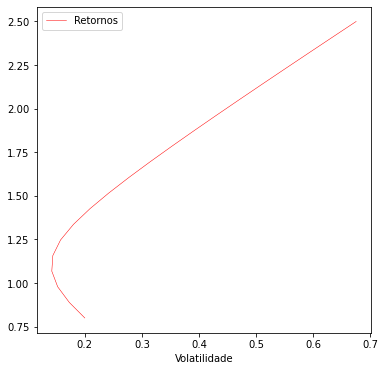

In [103]:
plot_ef(y_bar, V, p, 20)

# Portfólio de Mínima Norma 

In [104]:
def minimize_norm(er, cov, p):
    """
    Resolve o problema de minimizar a norma restrito ao preço ser igual a 1. Escala 
    o vetor para encontrar o vetor de precificação geral(alpha). 
    
        Parãmetros: 
        w (np.array nx1): portfolio
        er (np.array nx1): vetor de retornos esperados
        cov(np.array nx1): matriz de covariancia
        
        Retorna :
        pricing(np.array nx1): Vetor g de Precificação
    
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    
    prices_sum_to_1 = {'type': 'eq',
                        'fun': lambda w: w.T@p - 1
    }
    results = minimize(norm, init_guess,
                       args=(er, cov,), method="SLSQP",
                       options={"disp":False},
                       constraints=(prices_sum_to_1)
                      )
    
    
    min_norm_vector = results.x.reshape(n, 1)
    x = (V + y_bar@y_bar.T)[0, :]

    alpha = p[0]/np.sum(x@min_norm_vector)  # Encontrando o Fator de Escala.
    pricing_vector = alpha*min_norm_vector
    return {"Pricing Vector": pricing_vector, "Minimal Norm Vector": min_norm_vector}

# Optimal Portfolio Formulation 

In [105]:
def minus_risk_price(w, er, R_f, p, cov):
    """
    Dado o portfolio calcula o preço de risco. 
    
        Parâmetros: 
        w (np.array nx1): portfolio
        er (np.array nx1): vetor de retornos esperados
        cov(np.array nx1): matriz de covariancia
        p(np.array nx1): vetor de preços
        R_f(float): taxa livre de risco
        
        Retorna 
        sr(np.array 1x1): Retorno do portfolio
    """
    sr = (w.T@(er - R_f*p))/portfolio_volatiliy(w, cov)
    return -1*sr

def maximize_risk_price(er, cov, p, R_f):
    """
    Dado o portfolio calcula o portfólio que apresenta o maior preço de risco 
    restrito ao preço ser igual a um. 
    
        Parâmetros: 
        w (np.array nx1): portfolio
        er (np.array nx1): vetor de retornos esperados
        cov(np.array nx1): matriz de covariancia
        p(np.array nx1): vetor de preços
        R_f(float): taxa livre de risco
        
        Retorna 
        sr(np.array 1x1): Retorno do portfolio
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n).reshape(n,1)
    prices_sum_to_1 = {'type': 'eq',
                        'fun': lambda w: w.T@p - 1
    }
    results = minimize(minus_risk_price, init_guess,
                       args=(er, R_f, p, cov,), method="SLSQP",
                       options={"disp":False},
                       constraints=(prices_sum_to_1)
                      )
    vetor = results.x.reshape(n, 1)

    return vetor

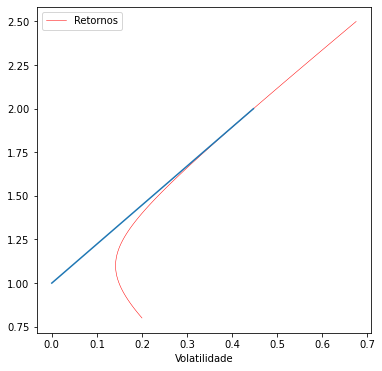

In [106]:
w_t = maximize_risk_price(y_bar, V, p, R_f)
R_t = float(portfolio_return(w_t, y_bar))
sigma_t =float(portfolio_volatiliy(w_t, V))

x = np.linspace(0, float(sigma_t))
y = (R_t - R_f)/sigma_t*x +R_f

ax = plot_ef(y_bar, V, p, 100)

ax.plot(x, y)

In [76]:
w_t

array([[ 2.00010978],
       [-1.00010978]])

In [43]:
y

array([1.        , 1.02040951, 1.04081902, 1.06122852, 1.08163803,
       1.10204754, 1.12245705, 1.14286655, 1.16327606, 1.18368557,
       1.20409508, 1.22450458, 1.24491409, 1.2653236 , 1.28573311,
       1.30614261, 1.32655212, 1.34696163, 1.36737114, 1.38778064,
       1.40819015, 1.42859966, 1.44900917, 1.46941867, 1.48982818,
       1.51023769, 1.5306472 , 1.5510567 , 1.57146621, 1.59187572,
       1.61228523, 1.63269473, 1.65310424, 1.67351375, 1.69392326,
       1.71433276, 1.73474227, 1.75515178, 1.77556129, 1.79597079,
       1.8163803 , 1.83678981, 1.85719932, 1.87760882, 1.89801833,
       1.91842784, 1.93883735, 1.95924685, 1.97965636, 2.00006587])